In [503]:
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime
import os
import matplotlib.pyplot as plt
import scipy
from scipy import signal

# Derive ON Signatures

In [521]:
SIG_SIZE = 90 # 1 sec contains 30 samples ; 3 seconds 90 samples.
THRSHLD =30
db = np.array([])
name = []
appliances = ['ceilingfan','drill', 'fan', 'hairdryer', 'heater', 'induction', 'iron', 'spinner', 'toaster', 'washing machine']

In [523]:
def get_train_sig(appliances,db,name):
    for appliance_name in appliances:
        data = pd.read_csv(f'../{appliance_name}.txt')
        data['Active Power']= abs(data['Active Power'])
        data['T'] = pd.to_datetime(data['T'])
        data = data.set_index(data['T'])
        data =  data.resample('33ms').mean()
        data = data.dropna()
        data = scipy.signal.medfilt(data['Active Power'], kernel_size=None)
        dbydx = np.gradient(data)
        on_events = []
        for idx,x in enumerate(dbydx):
            if x> THRSHLD:
                on_events.append(idx)
        for x in on_events:
            sig = data[x:x+SIG_SIZE]
            if len(sig) == SIG_SIZE:
                db = np.append(db,sig,axis = 0)
                name.append(f'{appliance_name}')
    return db, name

db, name = get_train_sig(appliances,db,name)

In [524]:
db = db.reshape((db.shape[0]//SIG_SIZE,SIG_SIZE))

In [525]:
len(db),db.shape

(1841, (1841, 90))

# Using Simple Models

In [526]:
def train_model(db, name):
    
    from sklearn.ensemble import RandomForestClassifier

    clf = RandomForestClassifier()

    from sklearn.model_selection import train_test_split

    X = db
    y = name

    X_train , X_test , y_train , y_test = train_test_split(X,y,test_size = 0.2,random_state=42)

    clf.fit(X_train,y_train)
    
    return clf,X_test,y_test

clf,X_test,y_test = train_model(db,name)

In [527]:
def pred_mains(clf,X_test,y_test=[]):
    if len(y_test) != 0:
        pred = clf.predict(X_test)
        preds = pred == y_test
        print(f'Total number of predictions = {preds.size}\n',
              f'Number of {np.unique(preds,return_counts=True)[0][0]} predictions = {np.unique(preds,return_counts=True)[1][0]}\n',
              f'Number of {np.unique(preds,return_counts=True)[0][1]} predictions= {np.unique(preds,return_counts=True)[1][1]}\n',
              f'Accuracy = {(np.unique(preds,return_counts=True)[1][1])/(preds.size)*100:.2f}%')
        return pred
    else:
        return clf.predict(X_test)

preds = pred_mains(clf,X_test,y_test)

Total number of predictions = 369
 Number of False predictions = 21
 Number of True predictions= 348
 Accuracy = 94.31%


# Create Dummy Data

In [528]:
def dummy(appliances):
    length = 27000

    vamp = (np.array([4]*length))
    for ix, appliance_name in enumerate(appliances):
        data = pd.read_csv(f'../{appliance_name}.txt')
        data['Active Power']= abs(data['Active Power'])
        data['T'] = pd.to_datetime(data['T'])
        data = data.set_index(data['T'])
        data =  data.resample('33ms').mean()
        data = data.dropna()
        data = scipy.signal.medfilt(data['Active Power'], kernel_size=None)
        dbydx =(np.gradient(data))
        on_events = []
        for idx,x in enumerate(dbydx):
            if x> THRSHLD:
                on_events.append(idx)
        for e in on_events:
            if data[e-1] < 10:
                x=e
                break
        mltplr = 1000*(1 + ix)
        sig = data[x:x+SIG_SIZE]
        if len(sig) == SIG_SIZE:
            sig = np.array(sig,dtype=float)
            _ = sig[-1]
            sig = np.append(sig,np.array([_]*(length-SIG_SIZE)))
            sig[2500:] = 0
            vamp[mltplr:] = np.add(vamp[mltplr:],sig[:(length-mltplr)])
    return vamp

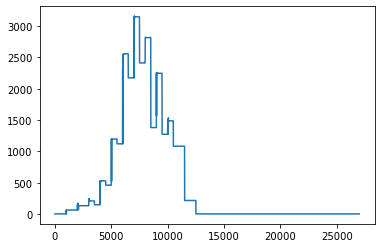

In [529]:
vamp = dummy(appliances)
plt.plot(vamp);

pd.Series(vamp).to_csv('../track_test.txt',index = False)

# Scenario

In [530]:
def get_value(indx):
    return vamp[indx:indx+SIG_SIZE]

In [531]:
vamp_db = np.array([])
data = scipy.signal.medfilt(vamp, kernel_size=None)
dbydx = (np.gradient(data))
on_events = []
for idx,x in enumerate(dbydx):
    if x > THRSHLD:
        on_events.append(idx)
for x in on_events:
#     print(on_events)
    for y in range(x+1,x+90): # to remove false turn on signatures, give delay for transition
        if y in on_events:
            on_events.remove(y)
            
for x in on_events:
    sig = data[x:x+SIG_SIZE]
    sig = sig - data[x-270:x].mean()
    if len(sig) == SIG_SIZE:
        vamp_db = np.append(vamp_db, sig, axis = 0)

In [532]:
vamp_db = vamp_db.reshape((vamp_db.shape[0]//SIG_SIZE,SIG_SIZE))

In [533]:
vamp_db.shape

(10, 90)

# Major Categorical Classification

In [534]:
test_preds = clf.predict(vamp_db)

df = pd.DataFrame({'Location':on_events,
             'Prediction': test_preds,
                  'actual':'na'})

In [535]:
for idx, x in enumerate(df['Location']):
    if x < 2000:
        df.loc[[idx],["actual"]] = appliances[0]
    elif x < 3000 and x >= 2000:
        df.loc[[idx],["actual"]] = appliances[1]
    elif x < 4000 and x >= 3000:
        df.loc[[idx],["actual"]] = appliances[2]
    elif x < 5000 and x >= 4000:
        df.loc[[idx],["actual"]] = appliances[3]
    elif x < 6000 and x >= 5000:
        df.loc[[idx],["actual"]] = appliances[4]
    elif x < 7000 and x >= 6000:
        df.loc[[idx],["actual"]] = appliances[5]
    elif x < 8000 and x >= 7000:
        df.loc[[idx],["actual"]] = appliances[6]
    elif x < 9000 and x >= 8000:
        df.loc[[idx],["actual"]] = appliances[7]
    elif x < 10000 and x >= 9000:
        df.loc[[idx],["actual"]] = appliances[8]
    elif x < 11000 and x >= 10000:
        df.loc[[idx],["actual"]] = appliances[9]

In [536]:
df

,Location,Prediction,actual
0,1000,ceilingfan,ceilingfan
1,2000,drill,drill
2,3000,fan,fan
3,4000,hairdryer,hairdryer
4,5000,heater,heater
5,6000,induction,induction
6,7000,iron,iron
7,8000,spinner,spinner
8,9000,toaster,toaster
9,10000,washing machine,washing machine


In [537]:
test_preds_proba = clf.predict_proba(vamp_db)

In [538]:
pd.DataFrame(test_preds_proba,columns=appliances)

,ceilingfan,drill,fan,hairdryer,heater,induction,iron,spinner,toaster,washing machine
0,0.99,0.0,0.00,0.00,0.0,0.01,0.0,0.00,0.00,0.00
1,0.02,0.9,0.08,0.00,0.0,0.00,0.0,0.00,0.00,0.00
2,0.00,0.1,0.89,0.00,0.0,0.00,0.0,0.01,0.00,0.00
3,0.00,0.0,0.00,1.00,0.0,0.00,0.0,0.00,0.00,0.00
4,0.00,0.0,0.00,0.00,1.0,0.00,0.0,0.00,0.00,0.00
5,0.00,0.0,0.00,0.17,0.0,0.83,0.0,0.00,0.00,0.00
6,0.00,0.0,0.00,0.07,0.0,0.02,0.9,0.00,0.01,0.00
7,0.00,0.0,0.00,0.01,0.0,0.00,0.0,0.99,0.00,0.00
8,0.00,0.0,0.00,0.03,0.0,0.00,0.0,0.00,0.97,0.00
9,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.17,0.00,0.83


# Tracking Devices

In [539]:
tracking_df = pd.DataFrame({'Location':on_events,
              'Prediction': test_preds,
              'Accuracy':[ x.max() for x in test_preds_proba]})
tracking_df

,Location,Prediction,Accuracy
0,1000,ceilingfan,0.99
1,2000,drill,0.90
2,3000,fan,0.89
3,4000,hairdryer,1.00
4,5000,heater,1.00
5,6000,induction,0.83
6,7000,iron,0.90
7,8000,spinner,0.99
8,9000,toaster,0.97
9,10000,washing machine,0.83


In [540]:
print(appliances)

['ceilingfan', 'drill', 'fan', 'hairdryer', 'heater', 'induction', 'iron', 'spinner', 'toaster', 'washing machine']


In [541]:
on_events

[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

In [542]:
active_devices = len(on_events)

In [543]:
import math
from statistics import mean

In [547]:
active_devices = 0
for x in on_events:
    active_devices += 1
    rise = (vamp[x+270:x+270+SIG_SIZE].mean()) - (vamp[x-270:x].mean())
    for idx, l in enumerate(vamp):
        if l>vamp[idx+1] and idx < len(vamp):
            fall = l - mean(vamp[idx+1:idx+91])
            if math.isclose(fall,rise,abs_tol=(rise*1/100)):
                loc = idx
                break
    duration = (loc-x)//30
    print(f'device no. {active_devices} turned on at location {x} with a rise of {rise} kWH & turned off at {loc} with a fall of {fall} & ran for {duration}s')

device no. 1 turned on at location 1000 with a rise of 62.0 kWH & turned off at 3499 with a fall of 62 & ran for 83s
device no. 2 turned on at location 2000 with a rise of 69.0 kWH & turned off at 4499 with a fall of 69 & ran for 83s
device no. 3 turned on at location 3000 with a rise of 76.0 kWH & turned off at 5499 with a fall of 76 & ran for 83s
device no. 4 turned on at location 4000 with a rise of 382.0 kWH & turned off at 6499 with a fall of 382 & ran for 83s
device no. 5 turned on at location 5000 with a rise of 735.0 kWH & turned off at 7499 with a fall of 735 & ran for 83s
device no. 6 turned on at location 6000 with a rise of 1434.0 kWH & turned off at 8499 with a fall of 1434 & ran for 83s
device no. 7 turned on at location 7000 with a rise of 972.0 kWH & turned off at 9499 with a fall of 972 & ran for 83s
device no. 8 turned on at location 8000 with a rise of 404.0 kWH & turned off at 10499 with a fall of 404 & ran for 83s
device no. 9 turned on at location 9000 with a rise

# Derive Signatures to train local database
* **Use signatures with high probability and club them together if they are running contagiously (tracking might help) and train the local model**
* **Once trained rerun the mains data to predict via local model**
* **Ask to name the clubbed signatures only once**

In [23]:
derived_db = np.array([])

In [24]:
for idx, x in enumerate(test_preds_proba):
    if x.max()<0.80:
        pos = on_events[idx]
        derived_sig = vamp[pos:pos+SIG_SIZE]
        if len(derived_sig) == SIG_SIZE:
            derived_db = np.append(derived_db,derived_sig,axis = 0)

derived_db = derived_db.reshape((derived_db.shape[0]//90,90))

In [25]:
derived_db.shape

(0, 90)

In [26]:
name = []
for x in derived_db:
    plt.plot(x)
    plt.show()
    new_sig = input('name this signal')
    name.append(new_sig)

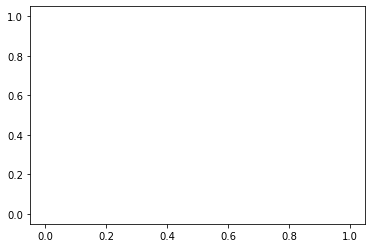

In [27]:
plt.plot(derived_db);

In [28]:
(vamp_db.shape)

(106, 90)